# Simple Analysis

For a single DR method/classifier.

In [1]:
import sys
path_scripts = '/home/noticed/supervised-DR-for-ASP/scripts/'
sys.path.append(path_scripts)

import IS_class as ip
from IS_class import InstanceSpace
import IS_eval as ipe
from proj_set import *

import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
metadata = pd.read_csv('./metadata/tsp.csv', index_col=0)
outpath = './results/tsp_all/'
selFeats = [c for c in metadata.columns if c.startswith('feature_')]


## Using Python + R

For DA methods and sparse variants of LDA, MDA and PLS.

In [3]:
## only needed if wanting to use methods in R
# prep(metadata, selFeats, outpath, scaler='s')

To use DA method implemented in R, run either of the following in the command line **after** running `prep()` :

`./da_par.r _outpath _ncores` (for default parameters)

`./da_par.r _outpath _ncores _gridSize` (for CV search, up to `_gridSize` parameters)


In [4]:
## create instance space object and load DA proj and predictions
iSpace = InstanceSpace()
iSpace.fromMetadata(metadata, scaler='s',best='Best',source='source')
iSpace.path = outpath

iSpace.dropFeatures(selFeats)

train_ind = list(pd.read_csv(outpath + 'metadata_train.csv')['instances'])
test_ind = list(pd.read_csv(outpath + 'metadata_test.csv')['instances'])
iSpace.splitData_known(train_ind, test_ind, scale=True)

## adds both DA methods
da_proj = pd.read_csv(outpath + 'da_proj.csv')
da_list = da_proj['proj'].unique()
for da in da_list:
    iSpace.addProj(da,da_proj.loc[da_proj['proj']==da])
    

Features dropped. Remaining features: 17
Manually adding MDA_s projection
Manually adding LDA_s projection


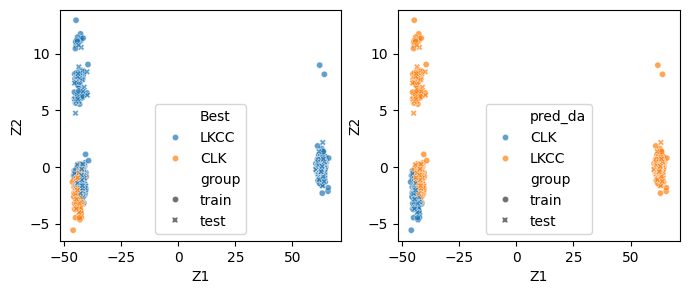

In [5]:
plt.subplots(1,2, figsize=(8,3))

plt.subplot(1,2,1)
iSpace.plot(proj='MDA_s', hue='Best')

plt.subplot(1,2,2)
iSpace.plot(proj='MDA_s', hue='pred_da')

### Prediction evaluation

In [6]:
is_pred = ipe.PredictionEval(iSpace.PlotProj, split=True)

for proj in is_pred.projections.keys():
    is_pred.evaluate_predictions(proj)
    is_pred.calc_regrets(proj,iSpace.performance,min=True,tie_lab=None)


In [7]:
pd.DataFrame.from_dict(is_pred.evals, orient='index').reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

,proj,pred_model,group,accuracy,precision,precision_w,recall,recall_m,f1,f1_w
0,MDA_s,da,train,0.893421,0.770992,0.889334,0.664474,0.807566,0.824150,0.890371
1,MDA_s,da,test,0.873684,0.769231,0.866041,0.526316,0.743421,0.774525,0.864241
2,LDA_s,da,train,0.967105,0.931973,0.966819,0.901316,0.942434,0.947956,0.966898
3,LDA_s,da,test,0.984211,0.972973,0.984137,0.947368,0.970395,0.975082,0.984131


In [8]:
regretDF = pd.concat(is_pred.regrets).reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

<Axes: xlabel='proj', ylabel='abs_reg'>

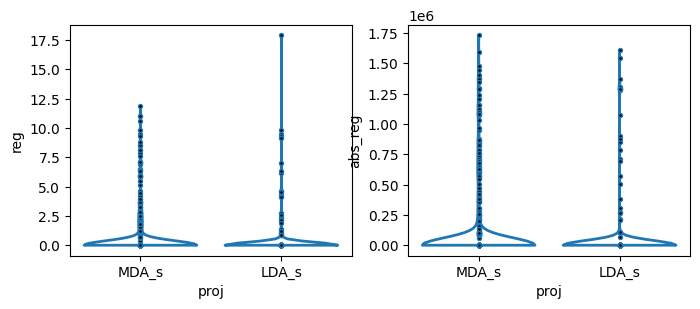

In [9]:
plt.subplots(1,2, figsize=(8,3))

plt.subplot(1,2,1)
sns.violinplot(
    data = regretDF, y='reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

plt.subplot(1,2,2)
sns.violinplot(
    data = regretDF, y='abs_reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

## Using only Python

If using a method in Python, no need to save to csv at each step:

In [10]:
iSpace = InstanceSpace()
iSpace.fromMetadata(metadata, scaler='s',best='Best',source='source')
iSpace.path = outpath
iSpace.dropFeatures(selFeats)

iSpace.splitData(test_size=0.2, random_state=1111,scale=True, stratified=True)
iSpace.PILOT(n_components=2,mode='a')


Features dropped. Remaining features: 17


In [11]:
iSpace.projections.keys()

dict_keys(['PILOTa'])

In [12]:
## predictions
is_pred = ipe.PredictionEval(iSpace.PlotProj, split=True)
proj = 'PILOTa'
is_pred.makePredictions_svm(proj, params={})


Same evaluation as before.

In [13]:
is_pred.evaluate_predictions(proj)
is_pred.calc_regrets(proj,iSpace.performance,min=True,tie_lab=None)


In [14]:
pd.DataFrame.from_dict(is_pred.evals, orient='index').reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

,proj,pred_model,group,accuracy,precision,precision_w,recall,recall_m,f1,f1_w
0,PILOTa,svm,train,0.930263,0.877863,0.928514,0.756579,0.865132,0.884938,0.928268
1,PILOTa,svm,test,0.878947,0.800000,0.872727,0.526316,0.746711,0.781183,0.868940


In [15]:
regretDF = pd.concat(is_pred.regrets).reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )

<Axes: xlabel='proj', ylabel='abs_reg'>

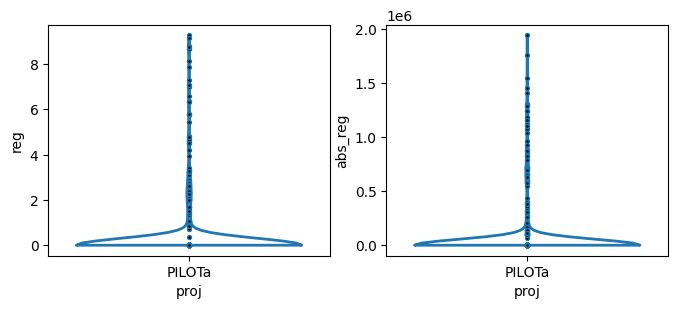

In [16]:
plt.subplots(1,2, figsize=(8,3))

plt.subplot(1,2,1)
sns.violinplot(
    data = regretDF, y='reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

plt.subplot(1,2,2)
sns.violinplot(
    data = regretDF, y='abs_reg', x='proj',
    inner='point', 
    cut=0, density_norm='count',
    fill=False, linewidth=2,
    inner_kws={'s':8, 'color': 'black'}
)

## Results from all_proj_run

In [17]:
with open(outpath +'iSpace.pkl', 'rb') as f:
    iSpace_all = pkl.load(f)

with open(outpath +'pred_eval.pkl', 'rb') as f:
    is_pred_all = pkl.load(f)

In [18]:
pred_eval_all = pd.read_csv(outpath + 'pred_eval.csv')

In [19]:
predAll_df = pred_eval_all.query('group=="test" & pred_model!="knn"')
predAll_df.index = predAll_df.apply(
    lambda x: x['proj'] if x['pred_model']=='da' else
        'Naive' if x['pred_model']=='avg' else
        f"{x['proj']}\n{x['pred_model']}", axis=1)

In [20]:
predAll_df

,proj,pred_model,group,accuracy,precision,precision_w,recall,recall_m,f1,f1_w
MDA_s,MDA_s,da,test,0.873684,0.769231,0.866041,0.526316,0.743421,0.774525,0.864241
LDA_s,LDA_s,da,test,0.984211,0.972973,0.984137,0.947368,0.970395,0.975082,0.984131
PCA\nsvm,PCA,svm,test,0.836842,0.666667,0.819724,0.368421,0.661184,0.689002,0.817657
PILOTa\nsvm,PILOTa,svm,test,0.878947,0.800000,0.872727,0.526316,0.746711,0.781183,0.868940
PLSR\nsvm,PLSR,svm,test,0.868421,0.782609,0.860713,0.473684,0.720395,0.755897,0.855337
PLSRrel\nsvm,PLSRrel,svm,test,0.889474,0.904762,0.891012,0.500000,0.743421,0.789324,0.876477
SLDA,SLDA,da,test,0.821053,0.552632,0.821053,0.552632,0.720395,0.720395,0.821053
SPLS\nsvm,SPLS,svm,test,0.868421,0.760000,0.859879,0.500000,0.730263,0.762155,0.857543
SrPLS\nsvm,SrPLS,svm,test,0.805263,0.529412,0.771778,0.236842,0.592105,0.606713,0.774378
All\nsvm,All,svm,test,0.921053,0.896552,0.919683,0.684211,0.832237,0.864098,0.916885


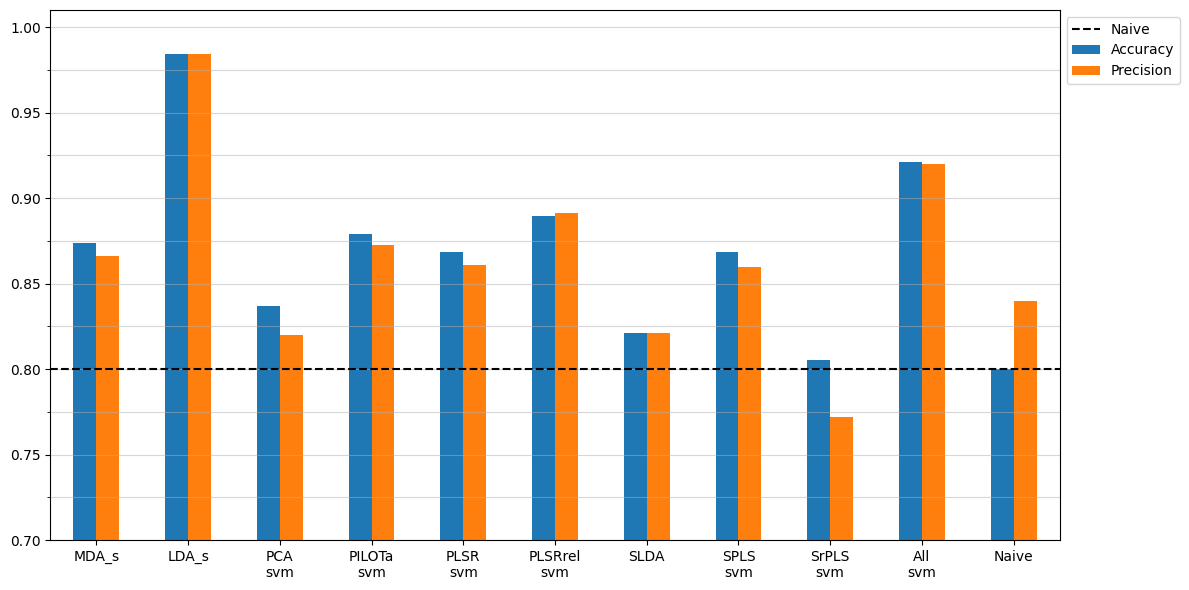

In [21]:
baseAcc = {'Naive': 0.8}
predAll_df[['accuracy','precision_w']].plot(kind='bar', figsize=(12,6),
                ylim=(0.7,1.01), xlabel='',rot=0)
# horizontal grid lines
plt.yticks(np.arange(0.7, 1.01, 0.025), minor=True)
plt.grid(axis='y', which='both', alpha=0.5)

# add horizontal line for base accuracy
plt.axhline(y=baseAcc['Naive'], color='black', linestyle='--', label='Naive')

# legend outside
# legend labels
plt.legend(['Naive','Accuracy','Precision','AUC'],bbox_to_anchor=(1, 1), loc='upper left')
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

In [22]:
regretDF_all = pd.concat(is_pred_all.regrets).reset_index().rename(
        columns={'level_0':'proj', 'level_1':'pred_model','level_2':'group'}
    )